In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

Using: cuda


In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/pytorch-tutorials-campusX/fashion-mnist_train.csv')
df_train.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4,0,0,0,5,4,5,5,3,5,...,7,8,7,4,3,7,5,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,14,0,0,0,0,0,0,0,0,0
7,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,0,0,3,2,0,...,1,0,0,0,0,0,0,0,0,0
9,8,0,0,0,0,0,0,0,0,0,...,203,214,166,0,0,0,0,0,0,0


In [5]:
df_test = pd.read_csv('/content/drive/MyDrive/pytorch-tutorials-campusX/fashion-mnist_test.csv')
df_test.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,44,105,44,10,...,105,64,30,0,0,0,0,0,0,0
6,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,6,0,0,0,0,0,0,0,1,0,...,174,136,155,31,0,1,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,57,70,28,0,2,0,0,0,0,0


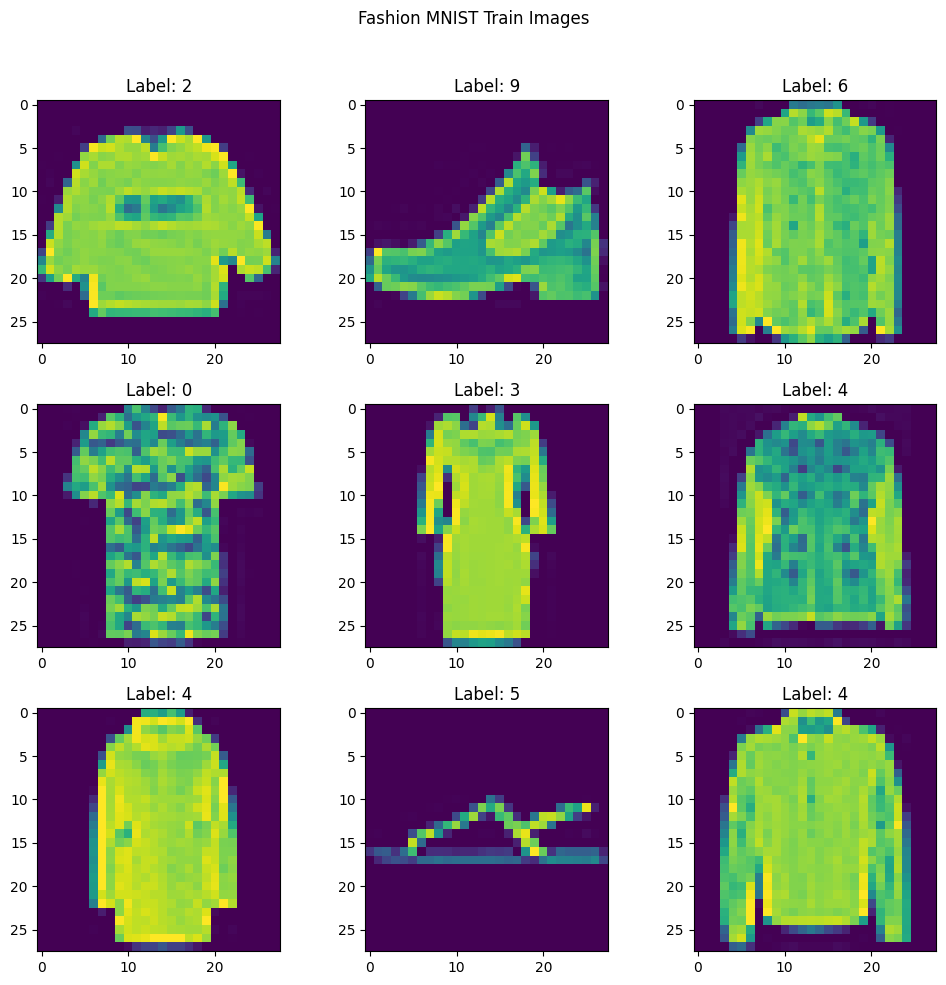

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Fashion MNIST Train Images')

for i, ax in enumerate(axes.flat):
  img = df_train.iloc[i, 1:].values.reshape(28, 28)
  ax.imshow(img)
  ax.set_title(f'Label: {df_train.iloc[i, 0]}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

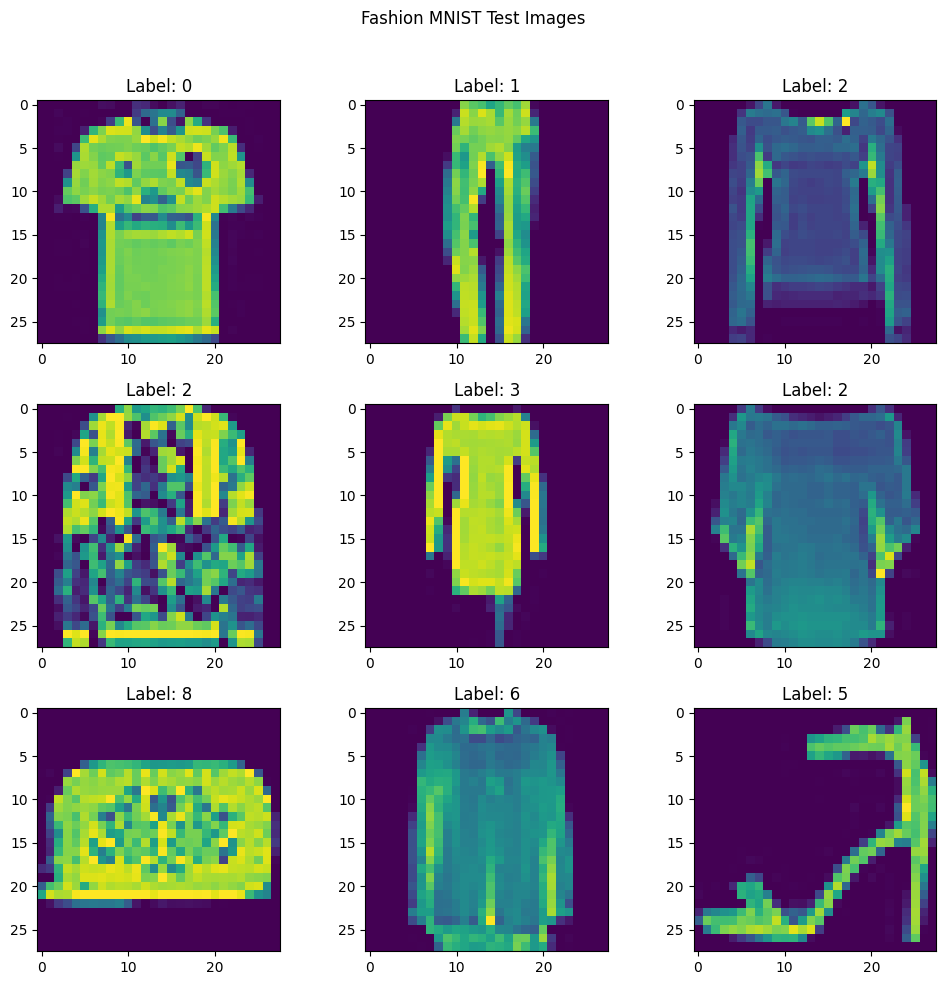

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Fashion MNIST Test Images')

for i, ax in enumerate(axes.flat):
  img = df_test.iloc[i, 1:].values.reshape(28, 28)
  ax.imshow(img)
  ax.set_title(f'Label: {df_test.iloc[i, 0]}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, 0].values

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
# scaling the feautures
X_train = X_train/255.0
X_val = X_val/255.0

In [11]:
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [12]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [15]:
class MLP(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.25),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    return self.model(x)

In [16]:
epochs = 100
learning_rate = 0.01

In [17]:
model = MLP(input_size=X_train.shape[1])
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [18]:
for epoch in range(epochs):
  train_epoch_loss = 0
  for features, labels in train_dataloader:
    features, labels = features.to(device), labels.to(device)

    # make a forward pass and find the logits
    logits = model(features)

    # calculate the cross entropy loss
    loss = criterion(logits, labels)

    # make gradients placeholder zero
    optimizer.zero_grad()

    # backpropagate the loss
    loss.backward()

    # update the parameters
    optimizer.step()

    train_epoch_loss += loss.item()

  avg_loss = train_epoch_loss/len(train_dataloader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 1.1190041616897692
Epoch: 2 , Loss: 0.6956548345359889
Epoch: 3 , Loss: 0.5924455167895014
Epoch: 4 , Loss: 0.5392254022034731
Epoch: 5 , Loss: 0.5094252899289131
Epoch: 6 , Loss: 0.4844168189235709
Epoch: 7 , Loss: 0.4672316055406224
Epoch: 8 , Loss: 0.4487383272498846
Epoch: 9 , Loss: 0.43614708369767125
Epoch: 10 , Loss: 0.4286460904404521
Epoch: 11 , Loss: 0.4187425971031189
Epoch: 12 , Loss: 0.4125386775386604
Epoch: 13 , Loss: 0.4026253634894436
Epoch: 14 , Loss: 0.39377603281966667
Epoch: 15 , Loss: 0.3893169455060905
Epoch: 16 , Loss: 0.38270282334732736
Epoch: 17 , Loss: 0.3777562591924586
Epoch: 18 , Loss: 0.3732796989127316
Epoch: 19 , Loss: 0.36680596245622094
Epoch: 20 , Loss: 0.35662196089767595
Epoch: 21 , Loss: 0.3573685165240683
Epoch: 22 , Loss: 0.3525037586434998
Epoch: 23 , Loss: 0.349781370298429
Epoch: 24 , Loss: 0.3415388795970516
Epoch: 25 , Loss: 0.33839622127230873
Epoch: 26 , Loss: 0.3343934019265527
Epoch: 27 , Loss: 0.3328730750998313
Epoch

In [19]:
# Set model to evaluation mode

model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
num_datapoints = 0
correct = 0
with torch.no_grad():

  for features, labels in val_dataloader:
    features, labels = features.to(device), labels.to(device)

    # make a forward pass and find the logits
    logits = model(features)
    pred_labels = torch.argmax(logits, dim=1)

    num_datapoints += labels.shape[0]
    correct += (pred_labels == labels).sum().item()

print(correct/num_datapoints)

0.8852666666666666


In [21]:
len(val_dataloader)

118

# TEST TIME

In [22]:
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

In [23]:
X_test= X_test/255.0

In [24]:
test_dataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [25]:
model.eval()

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [26]:
total = 0
correct = 0
with torch.no_grad():
  for features, labels in test_dataloader:
    features, labels = features.to(device), labels.to(device)

    logits = model(features)
    pred_labels = torch.argmax(logits, 1)

    total += labels.shape[0]
    correct += (pred_labels == labels).sum().item()

print(correct/total)


0.8868
